In [1]:
import numpy as np
import matplotlib.pyplot as plt
from synthetic import TestSuite
import torch

def RMSE_Loss(actual, predicted):
    """Root Mean Squared Error"""
    return torch.sqrt(torch.mean(torch.square(actual - predicted)))

def min_max_transform(series):
  series_temp = np.copy(series)
  for i in range(len(series_temp)):
    series_temp[i] = (series_temp[i] - np.max(series))/(np.max(series)-np.min(series)) + 1
  return series_temp

import os, shutil
DIR="experiment_nn_lstm/"
FILE_NAME=DIR+"/log.csv"
if os.path.exists(DIR): shutil.rmtree(DIR)
if not os.path.exists(DIR): os.mkdir(DIR)

In [2]:
def outputExperiment(id, series_name, mixed, feature_length, target_length, target_offset, rmse_train, rmse_test, epochs):
    with open(FILE_NAME, 'a') as f:
        result = ", ".join(map(str, list([id, series_name , mixed , feature_length , target_length , target_offset , rmse_train , rmse_test, epochs])))
        print(result, file=f)

In [3]:
def showExperiment(ID, mixed, series, series_name, Y_train, Y_test, Yhat_train, Yhat_test, Yhat_series, rmse_train, rmse_test):
    plt.figure(figsize=(30,10))
    plt.subplot(411)
    plt.margins(0.05)
    plt.plot(series)
    plt.plot(Yhat_series)
    plt.legend(["True", "Predicted"])
    plt.title("Series: "+ series_name+" (Random Sampling="+str(mixed)+")")

    plt.subplot(412)
    plt.margins(0.05)
    plt.plot(rmse_train)
    plt.plot(rmse_test)
    plt.legend(["RMSE Train", "RMSE Test"])
    plt.title("RMSE Train: "+ str(rmse_train[-1])+"\nRMSE Test: "+ str(rmse_test[-1]))

    plt.subplot(425)
    plt.margins(0.05)
    plt.plot(Y_train)
    plt.plot(Yhat_train)
    plt.legend(["True", "Predicted"])
    plt.title("Train")

    plt.subplot(426)
    plt.margins(0.05)
    plt.plot(Y_test)
    plt.plot(Yhat_test)
    plt.legend(["True", "Predicted"])
    plt.title("Test")

    plt.subplot(427)
    plt.margins(0.05)
    plt.plot(abs(Y_train - Yhat_train))
    plt.legend(["Residuals"])
    plt.title("Train")

    plt.subplot(428)
    plt.margins(0.05)
    plt.plot(abs(Y_test - Yhat_test))
    plt.legend(["Residuals"])
    plt.title("Test")

    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
    plt.savefig(DIR+str(ID)+".png", transparent=True)

# LSTM Neural Network

In [4]:
from src.models.nn import Model_LSTM

In [5]:
def executeNN(X_train, X_test, Y_train, Y_test):
    model_nn_lstm = Model_LSTM(error_fun=RMSE_Loss)
    model_nn_lstm.__train__(X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)

    rmse_train = model_nn_lstm.__get_error_train__()
    rmse_test = model_nn_lstm.__get_error_test__()

    yhat_train = model_nn_lstm.__get_yhat_train__()
    yhat_test = model_nn_lstm.__get_yhat_test__()

    X_series, Y_series = np.concatenate((X_train, X_test), axis=0), np.concatenate((Y_train, Y_test), axis=0)
    X_series, Y_series = torch.tensor(X_series, dtype=torch.float32), torch.tensor(Y_series, dtype=torch.float32)
    model_nn_lstm.__test__(X_test=X_series, Y_test=Y_series)
    yhat_series = model_nn_lstm.__get_yhat_test__()
    
    return rmse_train, rmse_test, yhat_train, yhat_test, yhat_series, model_nn_lstm.epochs

In [6]:
def PipelineNN():
    synthetic_dataset_test_suite = TestSuite()

    synthetic_datasets =  synthetic_dataset_test_suite.__get_test_suite_size__() - 5
    
    mixed = [True, False]
    feature_length = [1, 2, 3, 4, 5]
    target_offset = [1, 2, 3, 4, 5]
    target_length = [1]

    ID = 250 #0
    print("\t{}\t{}\t{}\t{}\t{}\t{}\t{}".format("ID", "Series", "Mixed", "Autoregressive Variables", "Target Length", "Target Offset", "RMSE Train", "RMSE Test", "EPOCHS"))
    for index in range(synthetic_datasets):
        series = synthetic_dataset_test_suite.__get_numpy_test_series_from_index__((index + 5))
        for ind_mixed in mixed:
            for ind_feature in feature_length:
                for ind_offset in target_offset:
                    for ind_target in target_length:
                        X_train, X_test, Y_train, Y_test = synthetic_dataset_test_suite.__train_and_test_from_numpy_series__(
                            transform=min_max_transform,
                            series=series,
                            mixed=ind_mixed,
                            feature_length=ind_feature,
                            offset=ind_offset,
                            target_length=ind_target,
                            tensor = True
                        )
                        rmse_train, rmse_test, yhat_train, yhat_test, yhat_series, epochs = executeNN(X_train=X_train, X_test=X_test, Y_train=Y_train, Y_test=Y_test)
                        outputExperiment(
                            ID,
                            synthetic_dataset_test_suite.__get_name_test_series_from_index__((index + 5)),
                            ind_mixed,
                            ind_feature,
                            ind_offset,
                            ind_target,
                            rmse_train[-1],
                            rmse_test[-1],
                            epochs
                        )
                        showExperiment(
                            ID,
                            ind_mixed,
                            np.concatenate((Y_train, Y_test), axis=0),
                            synthetic_dataset_test_suite.__get_name_test_series_from_index__(index),
                            Y_train.detach().numpy(),
                            Y_test.detach().numpy(),
                            yhat_train.detach().numpy(),
                            yhat_test.detach().numpy(),
                            yhat_series.detach().numpy(),
                            rmse_train,
                            rmse_test
                        )
                        ID += 1
    

In [7]:
# PipelineNN()

In [8]:
from sklearn.model_selection import KFold
class KFoldCrossValidation_LSTM():
  __RANDOM_SEED = 1

  def __init__(self, series, loss, one_step_offset_target, kfolds=10):
    self.series = series
    self.loss = loss
    self.target = one_step_offset_target
    self.kfolds = kfolds


  def __generate_train_validation_sets(self, X_train, Y_train, tensor=False): 
    kfold = KFold(n_splits=self.kfolds, shuffle=True, random_state=self.__RANDOM_SEED)
    new_X_train = []
    new_X_validation = []

    new_Y_train = []
    new_Y_validation = []
    for train_index, test_index in kfold.split(X_train):

      if(tensor is True):
        new_X_train.append(torch.tensor(X_train[train_index], dtype=torch.float32))
        new_Y_train.append(torch.tensor(Y_train[train_index], dtype=torch.float32))

        new_X_validation.append(torch.tensor(X_train[test_index], dtype=torch.float32))
        new_Y_validation.append(torch.tensor(Y_train[test_index], dtype=torch.float32))
      else:
        new_X_train.append(X_train[train_index])
        new_Y_train.append(Y_train[train_index])

        new_X_validation.append(X_train[test_index])
        new_Y_validation.append(Y_train[test_index])

    return np.array(new_X_train, dtype=object), np.array(new_X_validation, dtype=object), np.array(new_Y_train, dtype=object), np.array(new_Y_validation, dtype=object)

  def search(self, params):
    synthetic_dataset_test_suite = TestSuite()
    features_length = params["features_length"]
    rnn_layers = params["rnn_layers"]
    dropout = params["dropout"]
    hidden_state_size = params["hidden_state_size"]
    tensor = params["options"]["tensor"]

    cross_validation_results = []
    for ind_feature in features_length:
      for ind_rnn_layers in rnn_layers:
        for ind_hidden in hidden_state_size:
          for ind_dropout in dropout:
              X_train, _, Y_train, _ = synthetic_dataset_test_suite.__train_and_test_from_numpy_series__(
                  transform=min_max_transform,
                  series=self.series,
                  mixed=True,
                  feature_length=ind_feature,
                  offset=self.target,
                  target_length=1
              )
              

              X_trains, X_validations, Y_trains, Y_validations = self.__generate_train_validation_sets(X_train, Y_train, tensor=tensor)

              validation_loss = np.array([])
              for i in range(len(X_trains)):
                model_nn_lstm = Model_LSTM(error_fun=self.loss, num_layers=ind_rnn_layers, dropout=ind_dropout)
                model_nn_lstm.__train__(X_train=X_trains[i], Y_train=Y_trains[i], X_test=X_validations[i], Y_test=Y_validations[i])

                loss = model_nn_lstm.__get_error_test__()
                validation_loss = np.append(validation_loss, loss)
              
              mean = np.mean(validation_loss, axis=0)
              std = np.std(validation_loss, axis=0)
              params = {
                "features_length": ind_feature,
                "rnn_layers": ind_rnn_layers,
                "hidden_state_size": ind_hidden,
                "dropout": ind_dropout
              }
              print([mean, std, params, model_nn_lstm])
              cross_validation_results.append([mean, std, params, model_nn_lstm])
    
    cross_validation_results = np.array(cross_validation_results)
    min = cross_validation_results.T[0].min()
    index_min = np.where(cross_validation_results.T[0] == min)

    return cross_validation_results[index_min][0][2], cross_validation_results[index_min][0][3]  

In [ ]:
synthetic_dataset_test_suite = TestSuite()
cv_lstm = KFoldCrossValidation_LSTM(
    series = synthetic_dataset_test_suite.__get_numpy_test_series_from_index__(6),
    loss = RMSE_Loss,
    one_step_offset_target= 5
)
cross_validation_param = {
    "features_length": [10],
    "rnn_layers": [6],
    "dropout": [0.5],
    "hidden_state_size": [128, 256],
    "options": {
        "tensor": True
    }
}
params, model = cv_lstm.search(cross_validation_param)

In [ ]:
params

In [11]:
model

In [16]:
_, X_test, _, Y_test = synthetic_dataset_test_suite.__train_and_test_from_numpy_series__(
    transform=min_max_transform,
    series=synthetic_dataset_test_suite.__get_numpy_test_series_from_index__(6),
    mixed=False,
    feature_length=params["features_length"],
    offset=5,
    target_length=1
)

In [17]:
model.__test__(torch.tensor(X_test, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32))
yhat = model.__get_yhat_test__()

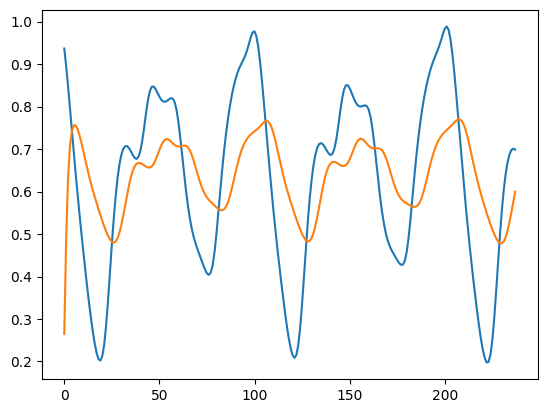

In [18]:
plt.plot(Y_test)
plt.plot(yhat)